# Calculating SEMB model parameters

In this notebook, we calculate the necessary parameters to calc the *Anomalous Bowen Ratio*, $\kappa$, using ERA5 data products. Here $\kappa$ is defined as
\begin{equation}
\kappa := \dfrac{\nu_{L} \gamma L}{\alpha}, 
\end{equation}
where $\nu_{L}$ is a surface resistence parameter, $L$ is the latent heat (enthalpy?) of vaporaization, $\gamma$ is the Clausius-Claperyon relation evaluated at the dew point temperature, and $\alpha$ is the dry feedback parameter.

$\alpha$, $\gamma$ and $\nu_{L}$ all need to be estimated from the data. We calculate them in the following and save the output to a NETCDF4 file.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt 
import glob 
import cartopy
import cartopy.crs as ccrs 

import sys
sys.path.append("/data/keeling/a/adammb4/heatwaves-physics/src/")
from getDataProcessing import *

## $\alpha$ estimation

We parameterize the net LW plus sensible plus ground heat flux as 
\begin{equation}
F_{LW} + H + G \equiv \alpha \left( T - T_{D} \right)
\end{equation}
where $T_{D}$ is the dew point temperature and $\alpha$ is the feedback parameter that we aim to estimate. We take $F_{LW}$ and $H$ from data, neglect $G$, and use regression to get $\alpha$.

In [2]:
# import data
alpha_PATH="/data/keeling/a/adammb4/heatwaves-physics/data/era5/"
lw_dataname = glob.glob(alpha_PATH+"netlw.nc")
else_dataname = glob.glob(alpha_PATH+"dewpt*")

lw_data = xr.open_dataset(lw_dataname[0])
else_data = xr.open_dataset(else_dataname[0])

In [3]:
lw_data

<xarray.Dataset>
Dimensions:    (latitude: 1801, longitude: 3600, time: 122)
Coordinates:
  * longitude  (longitude) float32 0.0 0.1 0.2 0.3 ... 359.6 359.7 359.8 359.9
  * latitude   (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * time       (time) datetime64[ns] 1981-06-01 1981-07-01 ... 2021-07-01
Data variables:
    str        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-10-06 19:30:24 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

In [4]:
else_data

<xarray.Dataset>
Dimensions:    (latitude: 1801, longitude: 3600, time: 122)
Coordinates:
  * longitude  (longitude) float32 0.0 0.1 0.2 0.3 ... 359.6 359.7 359.8 359.9
  * latitude   (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * time       (time) datetime64[ns] 1981-06-01 1981-07-01 ... 2021-07-01
Data variables:
    d2m        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    ssr        (time, latitude, longitude) float32 ...
    sshf       (time, latitude, longitude) float32 ...
    ssrd       (time, latitude, longitude) float32 ...
    e          (time, latitude, longitude) float32 ...
    swvl1      (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-10-06 17:42:26 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

In [5]:
sens = else_data["sshf"].values * 86400**(-1) # overall factor changes Joules per square meter to Watts per square meter
lw = lw_data["str"].values * 86400**(-1) # overall factor " "
temp = else_data["t2m"].values
dew_temp = else_data["d2m"].values

lat = else_data["latitude"].values
long = else_data["longitude"].values
time = else_data["time"].values

In [6]:
# removal JJA seasonal cycle
sens_anom = getRemove3MSeasonalCycle(sens)
lw_anom = getRemove3MSeasonalCycle(lw)

/data/keeling/a/adammb4/heatwaves-physics/src/getDataProcessing.py:128: RuntimeWarning: Mean of empty slice
  june_mean = np.nanmean(june_data, axis=0)
/data/keeling/a/adammb4/heatwaves-physics/src/getDataProcessing.py:129: RuntimeWarning: Mean of empty slice
  july_mean = np.nanmean(july_data, axis=0)
/data/keeling/a/adammb4/heatwaves-physics/src/getDataProcessing.py:130: RuntimeWarning: Mean of empty slice
  aug_mean = np.nanmean(aug_data, axis=0)


In [7]:
temp_anom = getRemove3MSeasonalCycle(temp - dew_temp)

In [8]:
# make total flux anomaly  
total_flux_anom = -1 * (lw_anom + sens_anom) # flip sign bc of sign convention 
                                             #(want fluxes to be positive, they are negative in ERA5 data)

In [9]:
# make DataArrays for regression
temp_anom_da = xr.DataArray(data=temp_anom, dims=["time", "lat", "long"])
total_flux_anom_da = xr.DataArray(data=total_flux_anom, dims=["time", "lat", "long"])

In [ ]:
# run regression at every point
alpha, intercept, pval, stderr, cov, cor = get2DLaggedRegression(temp_anom_da, total_flux_anom_da, 0, 0)

In [ ]:
alpha_num = alpha.values # convert DataArray to numpy array 

In [ ]:
alpha_ds = xr.Dataset({"alpha": (["lat", "long"], alpha_num),
                     },
                    coords={
                        "long": (["long"], long),
                        "lat": (["lat"], lat),
                    },
                    ) # want negative alpha values since we assumed it was positive

In [ ]:
fig1=plt.figure(figsize=(16,8))
ax1=plt.axes(projection=ccrs.PlateCarree(central_longitude=180.0))
ax1.coastlines()
ax1.add_feature(cartopy.feature.OCEAN,zorder=100,edgecolor='k')    
ax1.gridlines(draw_labels=True)
alpha_ds.alpha.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='afmhot', vmin=-5,vmax=25,
              cbar_kwargs={'label':'alpha (W m$^{-2}$ K$^{-1}$)','shrink':0.4,'orientation':'horizontal'})

fig1.savefig("./figures/10_21_2021_alphamap.png", dpi=400)
fig1.savefig("../docs/figdump/10_21_2021_alphamap.png", dpi=400)

In [ ]:
np.nanmean(alpha_num) # global

In [ ]:
np.nanmean(alpha_num[300:600,:]) # lat = 30 - 60 deg

In [ ]:
forplotting = alpha_num.flatten()
fig, ax = plt.subplots(figsize=(12,8))

ax.hist(forplotting, bins=40, range=(-25,50))
ax.set_xlabel(r"$\alpha$", fontsize=22)
fig.savefig("./figures/10_21_2021_histalpha.png", dpi=400)
fig.savefig("../docs/figdump/10_21_2021_histalpha.png", dpi=400)

## $\nu_{L}$ estimation

We parameterize total evaporation, $\mathcal{E}$, as 
\begin{equation}
\mathcal{E} = \nu_{L} m \left( q_{s} - q \right),
\end{equation}
where $m$ is the soil moisture fraction, $q_{s}$ is the specific humidity, and $\bar{q}$ is the humidity. We take $\mathcal{E}$, $m$, $q$ from data, and find $q_{s}$ using Clausius-Clapeyron,
\begin{equation}
q_{s}(T) = \dfrac{0.622\times 6.11}{P_{surf}} \exp\left( \dfrac{L}{R_{w}} \left[T_{0}^{-1} - T^{-1}\right] \right).
\end{equation}
We use the temperature values from the data to get $\tilde{q}_{s}(T)$. Then we can estimate $\nu_{L}$ as 
\begin{equation}
\nu_{L} = \bigg\langle \dfrac{\tilde{\mathcal{E}}}{\tilde{m} \left( \tilde{q}_{s} - \tilde{q} \right)} \bigg\rangle_{t},
\end{equation}
where angled brackets indicate the mean taken with respect to the subscripted variable, in this case, time *t*.

In [ ]:
spec_hum_dataname = alpha_PATH + "spec_hum.nc"
spec_hum_dataset = xr.open_dataset(spec_hum_dataname)
#spec_hum_dataset

In [ ]:
spec_hum_data = spec_hum_dataset["q"].values
lat_hum = spec_hum_dataset["latitude"].values
long_hum = spec_hum_dataset["longitude"].values
spec_hum_data = spec_hum_data[6:128,0,:,:] # take expver = 1, as this is considered to be the "final ERA5" product
# also only take months for which we have land data as well 

In [ ]:
hum_ds = xr.Dataset({"spec_hum": (["lat", "long"], np.nanmean(spec_hum_data, axis=0)),
                     },
                    coords={
                        "long": (["long"], long_hum),
                        "lat": (["lat"], lat_hum),
                    },
                    ) 

In [ ]:
fig1=plt.figure(figsize=(16,8))
ax1=plt.axes(projection=ccrs.PlateCarree(central_longitude=180.0))
ax1.coastlines()
#ax1.add_feature(cartopy.feature.OCEAN,zorder=100,edgecolor='k')    
ax1.gridlines(draw_labels=True)
hum_ds.spec_hum.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='afmhot',
              cbar_kwargs={'label':'specific humidity','shrink':0.4,'orientation':'horizontal'})

In [ ]:
evap_data = else_data["e"].values
volmois_data = else_data["swvl1"].values
moisfrac_data = volmois_data / np.nanmax(volmois_data,axis=0)

In [ ]:
evap_da = xr.DataArray(data=evap_data, dims=["time", "lat", "long"])
spec_hum_da = xr.DataArray(
    data=spec_hum_data, 
    dims=["time", "lat", "long"],
    coords={
        "long": (["long"], long_hum),
        "lat": (["lat"], lat_hum),
        "time": (["time"], time),
    }
    )
spec_hum_interp = spec_hum_da.interp(lat=lat, long=long, method="linear")

In [ ]:
spec_hum_nu = spec_hum_interp.values
spec_hum_nu.shape

In [ ]:
huminterp_ds = xr.Dataset({"spec_hum_interp": (["lat", "long"], np.mean(spec_hum_nu, axis=0)),
                     },
                    coords={
                        "long": (["long"], long),
                        "lat": (["lat"], lat),
                    },
                    ) 

In [ ]:
fig1=plt.figure(figsize=(16,8))
ax1=plt.axes(projection=ccrs.PlateCarree(central_longitude=180.0))
ax1.coastlines()
#ax1.add_feature(cartopy.feature.OCEAN,zorder=100,edgecolor='k')    
ax1.gridlines(draw_labels=True)
huminterp_ds.spec_hum_interp.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='afmhot',
              cbar_kwargs={'label':'specific humidity','shrink':0.4,'orientation':'horizontal'})

fig1.savefig("./figures/10_25_2021_interphumidity.png", dpi=400)
fig1.savefig("../docs/figdump/10_25_2021_interphumidity.png", dpi=400)

In [ ]:
P_surf = 101325 # Pa
L = 2.453e6 # J/kg
R_w = 461.52 #J/kg
T_0 = 273.15 # K

e_s = np.exp( L * R_w**(-1) * (T_0**(-1) - temp**(-1))) * 6.11 # 6.11 = vapor pressure @ T = T0

q_s_data = 0.622 * e_s * P_surf**(-1)

In [27]:
nu_data = evap_data * (moisfrac_data * (q_s_data - spec_hum_nu))**(-1)
nu = np.nanmean(nu_data, axis=0) # take time mean

<ipython-input-27-4ec8dfc9db4d>:1: RuntimeWarning: divide by zero encountered in reciprocal
  nu_data = evap_data * (moisfrac_data * (q_s_data - spec_hum_nu))**(-1)
<ipython-input-27-4ec8dfc9db4d>:2: RuntimeWarning: Mean of empty slice
  nu = np.nanmean(nu_data, axis=0) # take time mean


In [28]:
nu_L_ds = xr.Dataset({"nu_L": (["lat", "long"], nu),
                     },
                    coords={
                        "long": (["long"], long),
                        "lat": (["lat"], lat),
                    },
                    )

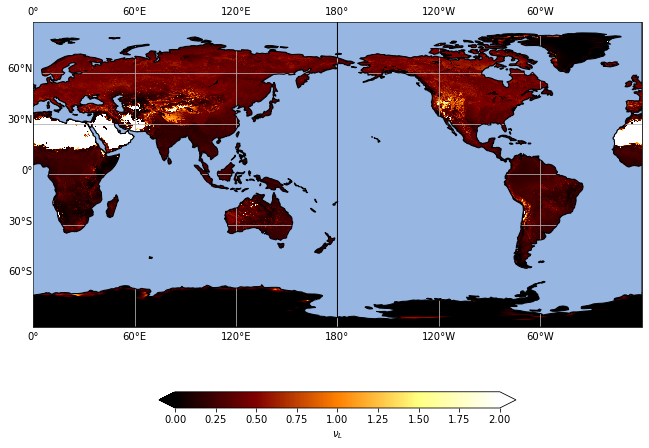

In [29]:
fig1=plt.figure(figsize=(16,8))
ax1=plt.axes(projection=ccrs.PlateCarree(central_longitude=180.0))
ax1.coastlines()
ax1.add_feature(cartopy.feature.OCEAN,zorder=100,edgecolor='k')    
ax1.gridlines(draw_labels=True)
nu_L_ds.nu_L.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='afmhot',vmin=0, vmax=2,
              cbar_kwargs={'label':r'$\nu_{L}$','shrink':0.4,'orientation':'horizontal'})

fig1.savefig("./figures/10_25_2021_nuL.png", dpi=400)
fig1.savefig("../docs/figdump/10_25_2021_nuL.png", dpi=400)

In [ ]:
VPD_da = xr.DataArray(data = moisfrac_data * (q_s_data - spec_hum_nu), dims=["time", "lat", "long"])

In [ ]:
nu_L_regress, intercept, pval, error, cov, cor = get2DLaggedRegression(VPD_da, evap_da, 0, 0)

In [ ]:
nu_Lr_ds = xr.Dataset({"nu_Lr": (["lat", "long"], nu_L_regress),
                     },
                    coords={
                        "long": (["long"], long),
                        "lat": (["lat"], lat),
                    },
                    )

In [ ]:
fig1=plt.figure(figsize=(16,8))
ax1=plt.axes(projection=ccrs.PlateCarree(central_longitude=180.0))
ax1.coastlines()
ax1.add_feature(cartopy.feature.OCEAN,zorder=100,edgecolor='k')    
ax1.gridlines(draw_labels=True)
nu_Lr_ds.nu_Lr.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='afmhot',vmin=0, vmax=2,
              cbar_kwargs={'label':r'$\nu_{L}$','shrink':0.4,'orientation':'horizontal'})

fig1.savefig("./figures/10_28_2021_nuL_regression.png", dpi=400)
fig1.savefig("../docs/figdump/10_28_2021_nuL_regression.png", dpi=400)

In [34]:
np.nanmean(nu_L_regress)

0.05027746555085293

## $\gamma$ estimation

$\gamma$ is estimated as the time average of the partial derivative in temperature of the Clausius-Clapeyron relationship, given by
\begin{equation}
\gamma = \bigg\langle \dfrac{0.622 \times 611 \times L}{P_{surf} R_{w} \tilde{T}_{D}^{2}} \exp\left( \dfrac{L}{R_{w}} \left( T_{0}^{-1} - \tilde{T}_{D}^{-1} \right)\right) \bigg\rangle_{t},
\end{equation}
where $\tilde{T}_{D}$ is estimated from data and $T_{0}$ I believe is 273 K. (It is 273 K. I checked.)

In [35]:
prefactor = 0.622 * L * (P_surf * R_w * dew_temp**2)**(-1) * 6.11
exp_term = np.exp(L * R_w**(-1) * (T_0**(-1) - dew_temp**(-1) ))

gamma_data = prefactor * exp_term
gamma = np.mean(gamma_data, axis=0) # take time average

In [36]:
gamma_ds = xr.Dataset({"gamma": (["lat", "long"], gamma),
                     },
                    coords={
                        "long": (["long"], long),
                        "lat": (["lat"], lat),
                    },
                    )

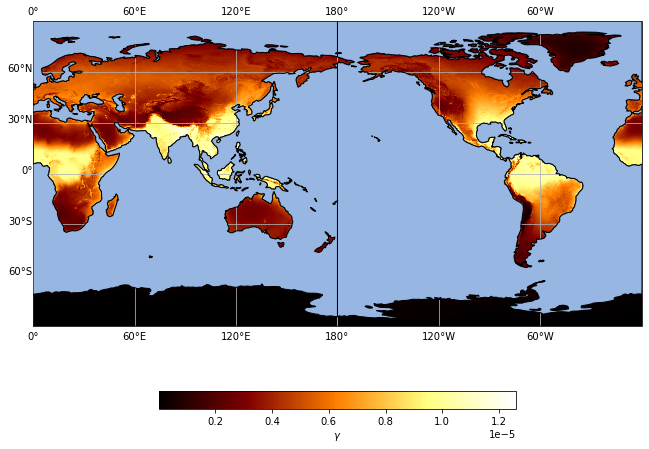

In [37]:
fig1=plt.figure(figsize=(16,8))
ax1=plt.axes(projection=ccrs.PlateCarree(central_longitude=180.0))
ax1.coastlines()
ax1.add_feature(cartopy.feature.OCEAN,zorder=100,edgecolor='k')    
ax1.gridlines(draw_labels=True)
gamma_ds.gamma.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='afmhot',
              cbar_kwargs={'label':'$\gamma$','shrink':0.4,'orientation':'horizontal'})

fig1.savefig("./figures/10_25_2021_gamma.png", dpi=400)
fig1.savefig("../docs/figdump/10_25_2021_gamma.png", dpi=400)

In [39]:
# save all of the above parameters to a netCDF. In order to do this, we must create a Dataset with all the variables
# used within it. 

all_ds = xr.Dataset(data_vars={"alpha": (["lat", "long"], alpha_num),
                     "nu_L": (["lat", "long"], nu_L_regress),
                     "gamma": (["lat", "long"], gamma),
                    },
                    coords={
                        "long": (["long"], long),
                        "lat": (["lat"], lat),
                    },
                    )

all_ds["alpha"].attrs = {"units":"W m$^{-2}$ K^{-1}", "long_name":"SlopeReg$(T-T_{D}, F_{LW} + \cal{H})$"}
all_ds["nu_L"].attrs = {"units":"dimensionless", "long_name":"SlopeReg$(m(q_{s}(T) - q), \cal{E})$"}
all_ds["gamma"].attrs = {"units":"K$^{-1}$", "long_name":"Deriv of CC eval at dew point temp"}

all_ds.to_netcdf(path="/data/keeling/a/adammb4/heatwaves-physics/data/era5/model_params3.nc", mode="w", format="NETCDF4", engine="netcdf4")

In [41]:
test = glob.glob(alpha_PATH + "model_params3.nc")
test_ds = xr.open_dataset(test[0])
test_ds

<xarray.Dataset>
Dimensions:  (lat: 1801, long: 3600)
Coordinates:
  * long     (long) float32 0.0 0.1 0.2 0.3 0.4 ... 359.6 359.7 359.8 359.9
  * lat      (lat) float32 90.0 89.9 89.8 89.7 89.6 ... -89.7 -89.8 -89.9 -90.0
Data variables:
    alpha    (lat, long) float64 ...
    nu_L     (lat, long) float64 ...
    gamma    (lat, long) float32 ...

# Old plots & such

In [ ]:
which = 80

ds_tempmean = xr.Dataset({"tempmean": (["lat", "long"], np.nanmean(temp, axis=0)),
                     },
                    coords={
                        "long": (["long"], long),
                        "lat": (["lat"], lat),
                    },
                    )

ds_tempanom = xr.Dataset({"tempanom": (["lat", "long"], np.nanmean(temp_anom, axis=0)),
                     },
                    coords={
                        "long": (["long"], long),
                        "lat": (["lat"], lat),
                    },
                    )

ds_lwmean = xr.Dataset({"lwmean": (["lat", "long"], np.nanmean(sens - lw, axis=0)),
                     },
                    coords={
                        "long": (["long"], long),
                        "lat": (["lat"], lat),
                    },
                    )

ds_lwanom = xr.Dataset({"lwanom": (["lat", "long"], np.nanmean(lw_anom + sens_anom, axis=0)),
                     },
                    coords={
                        "long": (["long"], long),
                        "lat": (["lat"], lat),
                    },
                    )

In [ ]:
fig1=plt.figure(figsize=(16,8))
ax1=plt.axes(projection=ccrs.PlateCarree(central_longitude=180.0))
ax1.coastlines()
ax1.add_feature(cartopy.feature.OCEAN,zorder=100,edgecolor='k')    
ax1.gridlines(draw_labels=True)
ds_tempmean.tempmean.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='afmhot',
              cbar_kwargs={'label':'Temp Mean (K)','shrink':0.4,'orientation':'horizontal'})

fig2=plt.figure(figsize=(16,8))
ax2=plt.axes(projection=ccrs.PlateCarree(central_longitude=180.0))
ax2.coastlines()
ax2.add_feature(cartopy.feature.OCEAN,zorder=100,edgecolor='k')    
ax2.gridlines(draw_labels=True)
ds_tempanom.tempanom.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap='afmhot',
              cbar_kwargs={'label':'Temp Mean Anom (K)','shrink':0.4,'orientation':'horizontal'})

fig=plt.figure(figsize=(16,8))
ax=plt.axes(projection=ccrs.PlateCarree(central_longitude=180.0))
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN,zorder=100,edgecolor='k')    
ax.gridlines(draw_labels=True)
ds_lwmean.lwmean.plot(ax=ax,transform=ccrs.PlateCarree(),cmap='afmhot',
              cbar_kwargs={'label':'LW Total Heat Flux Mean (W m$^{-2}$)','shrink':0.4,'orientation':'horizontal'})

fig4=plt.figure(figsize=(16,8))
ax4=plt.axes(projection=ccrs.PlateCarree(central_longitude=180.0))
ax4.coastlines()
ax4.add_feature(cartopy.feature.OCEAN,zorder=100,edgecolor='k')    
ax4.gridlines(draw_labels=True)
ds_lwanom.lwanom.plot(ax=ax4,transform=ccrs.PlateCarree(),cmap='afmhot',
              cbar_kwargs={'label':'LW Total Heat Flux Anomaly Mean (W m$^{-2}$)','shrink':0.4,'orientation':'horizontal'})